In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
raw_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(base_path)
sys.path.append(raw_path)
print(raw_path)
print(base_path)

/root/geonhee
/root/geonhee/pausa_mitsloan


In [10]:
import loader as io
import obso as obs
import xthreat as xthreat
from utils import get_dfl_match_result, get_bepro_match_result, calculate_points, get_team_standings, get_minutes_played

In [8]:
provider = "dfl"
data_dir = os.path.join(base_path, "data", provider, "elastic")
obso_dir = os.path.join(base_path, "data", provider, "obso")
print(f"Data dir: {data_dir}")
print(f"Obso dir: {obso_dir}")

Data dir: /root/geonhee/pausa_mitsloan/data/dfl/elastic
Obso dir: /root/geonhee/pausa_mitsloan/data/dfl/obso


## PAUSA

In [67]:
def calc_pausa(highlight, virtual_obso, before_margin=75, after_margin=25):
    """
    Calculate actual and optimal obso for a given event.
    
    args:
        highlight: pandas Series with event details (period_id, event_id, start_frame, end_x, end_y, receiver_code)
        virtual_obso: pandas DataFrame with virtual obso data
        before_margin: int, number of frames before the event to consider
        after_margin: int, number of frames after the event to consider
    """
    obso_df = virtual_obso[
        (virtual_obso["period_id"] == highlight.period_id) &
        (virtual_obso["event_id"] == highlight.event_id)
    ].reset_index(drop=True)

    obso_df = obso_df[
        (obso_df["trace_frame"] >= highlight.start_frame - before_margin) &
        (obso_df["trace_frame"] <= highlight.start_frame + after_margin)
    ]
    obso_map = obso_df.loc[obso_df["trace_frame"] == highlight.start_frame, "obso_map"].values[0]
    
    # Current time point's actual obso, optimal obso
    # Current time point's actual obso, optimal obso
    # 1. At the pass start time, use the obso_map and the receiver's start location to calculate the actual obso. 
    # actual_spatial_obso = obso_df.loc[obso_df["trace_frame"] == highlight.start_frame, highlight.receiver_code].values[0]
    
    # 2. At the pass start time, use the obso_map and the receiver's end location to calculate the actual obso. 
    end_x, end_y = highlight.end_x, highlight.end_y
    actual_spatial_obso = obs.calc_player_evaluate([end_x, end_y], obso_map) # actual spatial obso

    # optimal spatial ppcf, actual ppcf
    ppcf_map = obso_df.loc[obso_df["trace_frame"] == highlight.start_frame, "ppcf_map"].values[0]
    actual_spatial_ppcf = obs.calc_player_evaluate([end_x, end_y], ppcf_map) # actual spatial ppcf
    optimal_spatial_x, optimal_spatial_y = np.unravel_index(np.argmax(ppcf_map), ppcf_map.shape)
    optimal_spatial_ppcf = obs.calc_player_evaluate([optimal_spatial_x, optimal_spatial_y], ppcf_map) # optimal spatial ppcf

    optimal_spatial_obso = obso_map.max() # optimal spatial obso

    # optimal temporal obso
    optimal_temporal_obso = obso_df["obso_map"].apply(lambda m: np.max(m)).max()
    optimal_temporal_obso_idx = obso_df["obso_map"].apply(lambda m: np.max(m)).idxmax()
    optimal_temporal_obso_frame = obso_df.at[optimal_temporal_obso_idx, "trace_frame"]

    time_diff = (highlight.start_frame - optimal_temporal_obso_frame) * 0.04 # 25 FPS
    
    return actual_spatial_obso, optimal_spatial_obso, optimal_temporal_obso, time_diff, actual_spatial_ppcf, optimal_spatial_ppcf

In [68]:
game_ids = os.listdir(obso_dir)
game_ids = [id for id in game_ids if id in ["DFL-MAT-J03WMX", "DFL-MAT-J03WR9", "DFL-MAT-J03WN1", "DFL-MAT-J03WOH", "DFL-MAT-J03WOY", "DFL-MAT-J03WPY", "DFL-MAT-J03WQQ"]]
game_ids

['DFL-MAT-J03WOH',
 'DFL-MAT-J03WOY',
 'DFL-MAT-J03WN1',
 'DFL-MAT-J03WMX',
 'DFL-MAT-J03WQQ',
 'DFL-MAT-J03WPY',
 'DFL-MAT-J03WR9']

In [69]:
# every game aggregation
# open DFL data: DFL-MAT-J03WMX, DFL-MAT-J03WR9, DFL-MAT-J03WN1, DFL-MAT-J03WOH, DFL-MAT-J03WOY, DFL-MAT-J03WPY, DFL-MAT-J03WQQ
game_ids = os.listdir(obso_dir)
game_ids = ["DFL-MAT-J03WMX", "DFL-MAT-J03WR9", "DFL-MAT-J03WN1", "DFL-MAT-J03WOH", "DFL-MAT-J03WOY", "DFL-MAT-J03WPY", "DFL-MAT-J03WQQ"]
print(f"Found {len(game_ids)} games for provider {provider}.")

all_pass_df = []
for game_id in tqdm(game_ids):
    if provider == "dfl":
        loader = io.ElasticLoader(data_dir, game_id)
    elif provider == "bepro":
        loader = io.ElasticLoader(data_dir, game_id)
    else:
        raise ValueError(f"Unknown provider: {provider}")

    virtual_obso_dir = os.path.join(obso_dir, str(game_id), "virtual")
    if not os.path.exists(virtual_obso_dir):
        print(f"Virtual obso directory does not exist for game {game_id}. Skipping.")
        continue

    with open(os.path.join(virtual_obso_dir, "pass_events.pkl"), "rb") as f:
        pass_events = pickle.load(f) 
    pass_events = pass_events[
        pass_events["end_x"].notna() & 
        (pass_events["end_y"].notna())
    ].reset_index(drop=True)
    
    with open(os.path.join(virtual_obso_dir, "virtual_obso.pkl"), "rb") as f:
        virtual_obso = pickle.load(f) 
    with np.load(os.path.join(virtual_obso_dir, "virtual_obso_maps.npz")) as data:
        for col in data.files:
            virtual_obso[col] = list(data[col])
            
    pass_events["game_id"] = game_id
    pass_events = pass_events.merge(
        loader.meta_data[["player_id", "player_name", "team_name", "team_id", "playing_position"]],
        on="player_name", how="left"
    )
    
    results = [calc_pausa(row, virtual_obso) for row in pass_events.itertuples()]
    obso_df = pd.DataFrame(results, columns=[
        "actual_spatial_obso",
        "optimal_spatial_obso",
        "optimal_temporal_obso",
        "time_diff",
        "actual_spatial_ppcf",
        "optimal_spatial_ppcf"
    ])        
    df = pd.concat([pass_events, obso_df], axis=1)
    df['spatial_selection'] = df['actual_spatial_obso'] / df['optimal_spatial_obso']
    df['temporal_judgment'] = df['optimal_spatial_obso'] / df['optimal_temporal_obso']
    df['pausa'] = df['spatial_selection'] * df['temporal_judgment']
    df['ppcf_diff'] = df['actual_spatial_ppcf'] - df['optimal_spatial_ppcf']
    
    all_pass_df.append(df)

all_pass_df = pd.concat(all_pass_df).reset_index(drop=True)
all_pass_df

Found 7 games for provider dfl.


  0%|          | 0/7 [00:00<?, ?it/s]

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,...,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,time_diff,actual_spatial_ppcf,optimal_spatial_ppcf,spatial_selection,temporal_judgment,pausa,ppcf_diff
0,DFL-MAT-J03WMX,1,10547.0,10547.0,10586.0,21.88,23.44,Ryan Gravenberch,Away_38,Away_6,...,0.017133,0.019194,0.022130,-0.92,0.857877,0.096954,0.892624,0.867327,0.774197,0.760923
1,DFL-MAT-J03WMX,1,10586.0,10586.0,10623.0,23.44,24.92,Joshua Kimmich,Away_6,Away_10,...,0.013827,0.019302,0.021633,-1.00,0.893915,0.277928,0.716362,0.892214,0.639148,0.615987
2,DFL-MAT-J03WMX,1,10623.0,10721.0,10747.0,28.84,29.88,Leroy Sané,Away_10,Away_5,...,0.008089,0.016221,0.019243,2.24,0.978045,0.846395,0.498714,0.842946,0.420389,0.131650
3,DFL-MAT-J03WMX,1,10747.0,10812.0,10876.0,32.48,35.04,Benjamin Pavard,Away_5,Away_2,...,0.007601,0.013105,0.018339,2.60,0.979701,0.379479,0.579986,0.714574,0.414443,0.600222
4,DFL-MAT-J03WMX,1,10876.0,10876.0,10915.0,35.04,36.60,Dayot Upamecano,Away_2,Away_4,...,0.003111,0.013148,0.014425,-0.68,0.981364,0.982524,0.236613,0.911462,0.215664,-0.001160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,DFL-MAT-J03WQQ,2,167414.0,167440.0,167518.0,2697.60,2700.72,L. Paqarada,Away_23,Away_8,...,0.004921,0.009402,0.009559,0.80,0.783555,0.527998,0.523352,0.983566,0.514751,0.255557
3701,DFL-MAT-J03WQQ,2,167779.0,167779.0,167801.0,2711.16,2712.04,Eric Smith,Away_8,Away_23,...,0.013236,0.016842,0.017470,-0.36,0.937953,0.929114,0.785934,0.964013,0.757651,0.008839
3702,DFL-MAT-J03WQQ,2,167801.0,167845.0,167893.0,2713.80,2715.72,L. Paqarada,Away_23,Away_24,...,0.004100,0.013132,0.016582,1.76,0.907515,0.969569,0.312251,0.791939,0.247284,-0.062053
3703,DFL-MAT-J03WQQ,2,171724.0,171724.0,171754.0,2868.96,2870.16,Jackson Irvine,Away_7,Away_8,...,0.004095,0.015929,0.016049,-1.00,0.981207,0.870229,0.257065,0.992570,0.255155,0.110978


## xT(Expected Threat)

In [70]:
# xT Grid: Load xT model (URL or local path)
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json" 
url_grid = "../data/static/xT_grid.json"
xTModel = xthreat.load_model(url_grid)

In [71]:
all_pass_df["type_name"].value_counts()

type_name
pass     3666
cross      39
Name: count, dtype: int64

In [72]:
xT_df = all_pass_df.copy(deep=True)
# for calculating xT, adjust coordinates
for col in ["start_x", "end_x"]:
    xT_df[col] = xT_df[col] + 52.5
for col in ["start_y", "end_y"]:
    xT_df[col] = xT_df[col] + 34
xT_df["result_name"] = xT_df["result_name"].apply(lambda x: "success" if x == True else "fail")

# always convert to left->right to calculate xT
flip_cond = xT_df["team"] == "Away"
for col in ["start_x", "end_x"]:
    xT_df.loc[flip_cond, col] = 105 - xT_df.loc[flip_cond, col].values
for col in ["start_y", "end_y"]:
    xT_df.loc[flip_cond, col] = 68 - xT_df.loc[flip_cond, col].values
xT_df

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,...,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,time_diff,actual_spatial_ppcf,optimal_spatial_ppcf,spatial_selection,temporal_judgment,pausa,ppcf_diff
0,DFL-MAT-J03WMX,1,10547.0,10547.0,10586.0,21.88,23.44,Ryan Gravenberch,Away_38,Away_6,...,0.017133,0.019194,0.022130,-0.92,0.857877,0.096954,0.892624,0.867327,0.774197,0.760923
1,DFL-MAT-J03WMX,1,10586.0,10586.0,10623.0,23.44,24.92,Joshua Kimmich,Away_6,Away_10,...,0.013827,0.019302,0.021633,-1.00,0.893915,0.277928,0.716362,0.892214,0.639148,0.615987
2,DFL-MAT-J03WMX,1,10623.0,10721.0,10747.0,28.84,29.88,Leroy Sané,Away_10,Away_5,...,0.008089,0.016221,0.019243,2.24,0.978045,0.846395,0.498714,0.842946,0.420389,0.131650
3,DFL-MAT-J03WMX,1,10747.0,10812.0,10876.0,32.48,35.04,Benjamin Pavard,Away_5,Away_2,...,0.007601,0.013105,0.018339,2.60,0.979701,0.379479,0.579986,0.714574,0.414443,0.600222
4,DFL-MAT-J03WMX,1,10876.0,10876.0,10915.0,35.04,36.60,Dayot Upamecano,Away_2,Away_4,...,0.003111,0.013148,0.014425,-0.68,0.981364,0.982524,0.236613,0.911462,0.215664,-0.001160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,DFL-MAT-J03WQQ,2,167414.0,167440.0,167518.0,2697.60,2700.72,L. Paqarada,Away_23,Away_8,...,0.004921,0.009402,0.009559,0.80,0.783555,0.527998,0.523352,0.983566,0.514751,0.255557
3701,DFL-MAT-J03WQQ,2,167779.0,167779.0,167801.0,2711.16,2712.04,Eric Smith,Away_8,Away_23,...,0.013236,0.016842,0.017470,-0.36,0.937953,0.929114,0.785934,0.964013,0.757651,0.008839
3702,DFL-MAT-J03WQQ,2,167801.0,167845.0,167893.0,2713.80,2715.72,L. Paqarada,Away_23,Away_24,...,0.004100,0.013132,0.016582,1.76,0.907515,0.969569,0.312251,0.791939,0.247284,-0.062053
3703,DFL-MAT-J03WQQ,2,171724.0,171724.0,171754.0,2868.96,2870.16,Jackson Irvine,Away_7,Away_8,...,0.004095,0.015929,0.016049,-1.00,0.981207,0.870229,0.257065,0.992570,0.255155,0.110978


In [73]:
mov_actions = xthreat.get_successful_move_actions(xT_df)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,...,optimal_spatial_obso,optimal_temporal_obso,time_diff,actual_spatial_ppcf,optimal_spatial_ppcf,spatial_selection,temporal_judgment,pausa,ppcf_diff,xT_value
0,DFL-MAT-J03WMX,1,10547.0,10547.0,10586.0,21.88,23.44,Ryan Gravenberch,Away_38,Away_6,...,0.019194,0.022130,-0.92,0.857877,0.096954,0.892624,0.867327,0.774197,0.760923,-0.001827
1,DFL-MAT-J03WMX,1,10586.0,10586.0,10623.0,23.44,24.92,Joshua Kimmich,Away_6,Away_10,...,0.019302,0.021633,-1.00,0.893915,0.277928,0.716362,0.892214,0.639148,0.615987,0.002604
2,DFL-MAT-J03WMX,1,10623.0,10721.0,10747.0,28.84,29.88,Leroy Sané,Away_10,Away_5,...,0.016221,0.019243,2.24,0.978045,0.846395,0.498714,0.842946,0.420389,0.131650,-0.003971
3,DFL-MAT-J03WMX,1,10747.0,10812.0,10876.0,32.48,35.04,Benjamin Pavard,Away_5,Away_2,...,0.013105,0.018339,2.60,0.979701,0.379479,0.579986,0.714574,0.414443,0.600222,-0.001368
4,DFL-MAT-J03WMX,1,10876.0,10876.0,10915.0,35.04,36.60,Dayot Upamecano,Away_2,Away_4,...,0.013148,0.014425,-0.68,0.981364,0.982524,0.236613,0.911462,0.215664,-0.001160,-0.000729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,DFL-MAT-J03WQQ,2,167414.0,167440.0,167518.0,2697.60,2700.72,L. Paqarada,Away_23,Away_8,...,0.009402,0.009559,0.80,0.783555,0.527998,0.523352,0.983566,0.514751,0.255557,0.001980
3701,DFL-MAT-J03WQQ,2,167779.0,167779.0,167801.0,2711.16,2712.04,Eric Smith,Away_8,Away_23,...,0.016842,0.017470,-0.36,0.937953,0.929114,0.785934,0.964013,0.757651,0.008839,0.000336
3702,DFL-MAT-J03WQQ,2,167801.0,167845.0,167893.0,2713.80,2715.72,L. Paqarada,Away_23,Away_24,...,0.013132,0.016582,1.76,0.907515,0.969569,0.312251,0.791939,0.247284,-0.062053,0.004412
3703,DFL-MAT-J03WQQ,2,171724.0,171724.0,171754.0,2868.96,2870.16,Jackson Irvine,Away_7,Away_8,...,0.015929,0.016049,-1.00,0.981207,0.870229,0.257065,0.992570,0.255155,0.110978,-0.004035


In [74]:
mov_actions["playing_position"].unique()

array(['LDM', 'RDM', 'RAM', 'RB', 'RCB', 'LCB', 'GK', 'LB', 'CAM', 'LAM',
       'CF', 'RCF', 'LCF', 'RWF', 'LWF', 'RCM', 'CB', 'LCM', 'CDM', 'RM',
       'LM'], dtype=object)

In [75]:
simplified_position_map = {
    'GK': 'GK',

    'CB': 'CB', 
    'LCB': 'CB', 
    'RCB': 'CB',

    'LB': 'FB', 
    'LWB': 'FB',
    'RB': 'FB',
    'RWB': "FB",

    'CDM': 'CDM', 
    'LDM': 'CDM', 
    'RDM': 'CDM',

    'CM': 'CM', 
    'LCM': 'CM', 
    'RCM': 'CM',
    
    'LM': 'WF', 
    'RM': 'WF',
    'LWF': 'WF', 
    'RWF': 'WF',

    'CAM': 'CAM', 
    'LAM': 'CAM', 
    'RAM': 'CAM',

    'CF': 'CF', 
    'LCF': 'CF', 
    'RCF': 'CF',
}

## PoP (Pace of Play)

In [77]:
merged_df = mov_actions.copy(deep=True)
merged_df["Pop"] = (merged_df.start_frame - merged_df.receive_frame) * (1/25)  # 25 fps
merged_df

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,...,optimal_temporal_obso,time_diff,actual_spatial_ppcf,optimal_spatial_ppcf,spatial_selection,temporal_judgment,pausa,ppcf_diff,xT_value,Pop
0,DFL-MAT-J03WMX,1,10547.0,10547.0,10586.0,21.88,23.44,Ryan Gravenberch,Away_38,Away_6,...,0.022130,-0.92,0.857877,0.096954,0.892624,0.867327,0.774197,0.760923,-0.001827,0.00
1,DFL-MAT-J03WMX,1,10586.0,10586.0,10623.0,23.44,24.92,Joshua Kimmich,Away_6,Away_10,...,0.021633,-1.00,0.893915,0.277928,0.716362,0.892214,0.639148,0.615987,0.002604,0.00
2,DFL-MAT-J03WMX,1,10623.0,10721.0,10747.0,28.84,29.88,Leroy Sané,Away_10,Away_5,...,0.019243,2.24,0.978045,0.846395,0.498714,0.842946,0.420389,0.131650,-0.003971,3.92
3,DFL-MAT-J03WMX,1,10747.0,10812.0,10876.0,32.48,35.04,Benjamin Pavard,Away_5,Away_2,...,0.018339,2.60,0.979701,0.379479,0.579986,0.714574,0.414443,0.600222,-0.001368,2.60
4,DFL-MAT-J03WMX,1,10876.0,10876.0,10915.0,35.04,36.60,Dayot Upamecano,Away_2,Away_4,...,0.014425,-0.68,0.981364,0.982524,0.236613,0.911462,0.215664,-0.001160,-0.000729,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,DFL-MAT-J03WQQ,2,167414.0,167440.0,167518.0,2697.60,2700.72,L. Paqarada,Away_23,Away_8,...,0.009559,0.80,0.783555,0.527998,0.523352,0.983566,0.514751,0.255557,0.001980,1.04
3701,DFL-MAT-J03WQQ,2,167779.0,167779.0,167801.0,2711.16,2712.04,Eric Smith,Away_8,Away_23,...,0.017470,-0.36,0.937953,0.929114,0.785934,0.964013,0.757651,0.008839,0.000336,0.00
3702,DFL-MAT-J03WQQ,2,167801.0,167845.0,167893.0,2713.80,2715.72,L. Paqarada,Away_23,Away_24,...,0.016582,1.76,0.907515,0.969569,0.312251,0.791939,0.247284,-0.062053,0.004412,1.76
3703,DFL-MAT-J03WQQ,2,171724.0,171724.0,171754.0,2868.96,2870.16,Jackson Irvine,Away_7,Away_8,...,0.016049,-1.00,0.981207,0.870229,0.257065,0.992570,0.255155,0.110978,-0.004035,0.00


## Standing Tables

In [79]:
def calc_match_result(match_id_list, base_path, provider):
    match_results = []

    if provider == "dfl":
        raw_data_dir = os.path.join(base_path, "..", "Data", provider, "raw")

        for match_id in match_id_list:
            match_path = os.path.join(raw_data_dir, match_id)

            if not os.path.isdir(match_path):
                continue

            file_name_info = next(
                (
                    fn for fn in os.listdir(match_path)
                    if "matchinformation" in fn.lower() or "spielinformationen" in fn.lower()
                ),
                None
            )
            if file_name_info is None:
                continue

            match_info_path = os.path.join(match_path, file_name_info)
            result = get_dfl_match_result(match_info_path)

            if result and result.get("home_goals") is not None:
                #result["match_id"] = match_id
                match_results.append(result)
                
    elif provider == "bepro":
        raw_data_dir = os.path.join(base_path, "..", "Data", provider, "raw_research", "2024")

        for match_id in tqdm(match_id_list):
            metadata_path = os.path.join(raw_data_dir, str(match_id), f"{match_id}_metadata.json")
            result = get_bepro_match_result(metadata_path)
            result["match_id"] = match_id
            match_results.append(result)

    else:
        raise ValueError(f"Unsupported provider: {provider}")

    print(f"Collected match results for {len(match_results)} matches.")
    return pd.DataFrame(match_results)

matches_df = calc_match_result(
    match_id_list=list(merged_df.game_id.unique()),
    base_path=base_path,
    provider=provider
)

print("\n=== Match Results ===")
matches_df

Collected match results for 7 matches.

=== Match Results ===


,competition_name,season_name,match_date,home_team,guest_team,home_goals,guest_goals,result_str
0,Bundesliga,2022/2023,2023-05-27T13:30:00.000+00:00,1. FC Köln,FC Bayern München,1,2,1:2
1,2. Bundesliga,2022/2023,2022-11-11T17:30:00.000+00:00,Fortuna Düsseldorf,1. FC Kaiserslautern,1,2,1:2
2,Bundesliga,2022/2023,2023-05-27T13:30:00.000+00:00,VfL Bochum 1848,Bayer 04 Leverkusen,3,0,3:0
3,2. Bundesliga,2022/2023,2022-08-26T16:30:00.000+00:00,Fortuna Düsseldorf,SSV Jahn Regensburg,4,0,4:0
4,2. Bundesliga,2022/2023,2022-09-10T18:30:00.000+00:00,Fortuna Düsseldorf,F.C. Hansa Rostock,3,1,3:1
5,2. Bundesliga,2022/2023,2022-10-15T11:00:00.000+00:00,Fortuna Düsseldorf,1. FC Nürnberg,0,1,0:1
6,2. Bundesliga,2022/2023,2022-11-05T12:00:00.000+00:00,Fortuna Düsseldorf,FC St. Pauli,1,0,1:0


In [80]:
standings_df = get_team_standings(matches_df)
standings_df.sort_values(by="ppg", ascending=False)

,Rank,team,played,Win,Draw,Lose,goals_for,goals_against,goal_diff,points,ppg
1,2,VfL Bochum 1848,1,1,0,0,3,0,3,3,3.0
2,3,FC Bayern München,1,1,0,0,2,1,1,3,3.0
3,4,1. FC Kaiserslautern,1,1,0,0,2,1,1,3,3.0
4,5,1. FC Nürnberg,1,1,0,0,1,0,1,3,3.0
0,1,Fortuna Düsseldorf,5,3,0,2,9,4,5,9,1.8
5,6,1. FC Köln,1,0,0,1,1,2,-1,0,0.0
6,7,FC St. Pauli,1,0,0,1,0,1,-1,0,0.0
7,8,F.C. Hansa Rostock,1,0,0,1,1,3,-2,0,0.0
8,9,Bayer 04 Leverkusen,1,0,0,1,0,3,-3,0,0.0
9,10,SSV Jahn Regensburg,1,0,0,1,0,4,-4,0,0.0


## Player Info Tables

In [81]:
def calc_minutes_played(match_id_list, base_path, provider):
    match_results = []

    raw_data_dir = os.path.join(base_path, "data", provider, "elastic")

    for match_id in tqdm(match_id_list[:]):
        meta_data_path = os.path.join(raw_data_dir, match_id, "meta_data.parquet")
        trace_path = os.path.join(raw_data_dir, match_id, "tracking.parquet")

        result = get_minutes_played(meta_data_path, trace_path)
        result["match_id"] = match_id
        match_results.append(result)
                
    print(f"Collected match results for {len(match_results)} matches.")
    return pd.concat(match_results, ignore_index=True)

player_games = calc_minutes_played(
    match_id_list=list(merged_df.game_id.unique()),
    base_path=base_path,
    provider=provider
)

print("\n=== Player Games ===")
player_games

  0%|          | 0/7 [00:00<?, ?it/s]

Collected match results for 7 matches.

=== Player Games ===


,player_id,minutes_played,match_id
0,DFL-OBJ-0000IA,62.973333,DFL-MAT-J03WMX
1,DFL-OBJ-0000RP,24.660000,DFL-MAT-J03WMX
2,DFL-OBJ-00012X,97.168000,DFL-MAT-J03WMX
3,DFL-OBJ-000191,13.210667,DFL-MAT-J03WMX
4,DFL-OBJ-000270,62.973333,DFL-MAT-J03WMX
...,...,...,...
213,DFL-OBJ-J0157X,69.796667,DFL-MAT-J03WQQ
214,DFL-OBJ-J01HCH,24.088667,DFL-MAT-J03WQQ
215,DFL-OBJ-J01KJ5,94.598667,DFL-MAT-J03WQQ
216,DFL-OBJ-J01L1F,27.377333,DFL-MAT-J03WQQ


In [ ]:
player_infos = player_games.groupby('player_id').agg(
    total_minutes_played=('minutes_played', 'sum'), # Total Minutes Played
    total_games=('match_id', 'nunique'),  # Total Games Played
).reset_index()

player_infos[player_infos.total_minutes_played >= 300].sort_values("total_minutes_played", ascending=False)

,player_id,total_minutes_played,total_games
11,DFL-OBJ-0000NZ,472.948000,5
78,DFL-OBJ-0028FW,472.948000,5
91,DFL-OBJ-002FXT,413.823333,5
120,DFL-OBJ-002GM9,406.509333,5
121,DFL-OBJ-002GMO,382.566667,4
158,DFL-OBJ-J01KJ5,382.566667,4
32,DFL-OBJ-00028V,378.349333,4
119,DFL-OBJ-002GM1,311.179333,5
129,DFL-OBJ-J0130T,303.803333,4


## Pass Completion Rate

In [83]:
# every game aggregation
all_pass_success_rate_df = []
for game_id in tqdm(merged_df.game_id.unique()):
    if provider == "dfl":
        loader = io.ElasticLoader(data_dir, game_id)
    elif provider == "bepro":
        loader = io.ElasticLoader(data_dir, game_id)
    else:
        raise ValueError(f"Unknown provider: {provider}")

    events = loader.get_event_data()

    pass_events = events[events["spadl_type"].isin(["pass", "cross"])].reset_index(drop=True)
    pass_events = pass_events.merge(
        loader.meta_data[["player_id", "team_name"]],
        on="player_id", how="left"
    )

    all_pass_success_rate_df.extend([{
        "game_id": game_id,
        "type_name": row.spadl_type,
        "result_name": row.success,
        "player_id": row.player_id,
        "player_name": row.player_name,
        "team_id": row.team_id,
        "team_name": row.team_name,
    } for row in pass_events.itertuples()])
    
all_pass_success_rate_df = pd.DataFrame(all_pass_success_rate_df)
all_pass_success_rate_df

  0%|          | 0/7 [00:00<?, ?it/s]

/root/geonhee/pausa_mitsloan/loader.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_df = pd.concat([event_df, receive_event_df], ignore_index=True)
/root/geonhee/pausa_mitsloan/loader.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_df = pd.concat([event_df, receive_event_df], ignore_index=True)
/root/geonhee/pausa_mitsloan/loader.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no lon

,game_id,type_name,result_name,player_id,player_name,team_id,team_name
0,DFL-MAT-J03WMX,pass,True,DFL-OBJ-0027G6,Serge Gnabry,DFL-CLU-00000G,FC Bayern München
1,DFL-MAT-J03WMX,pass,False,DFL-OBJ-0027KL,Dayot Upamecano,DFL-CLU-00000G,FC Bayern München
2,DFL-MAT-J03WMX,pass,True,DFL-OBJ-J01B8N,Ryan Gravenberch,DFL-CLU-00000G,FC Bayern München
3,DFL-MAT-J03WMX,pass,True,DFL-OBJ-0002F5,Joshua Kimmich,DFL-CLU-00000G,FC Bayern München
4,DFL-MAT-J03WMX,pass,True,DFL-OBJ-0002AU,Leroy Sané,DFL-CLU-00000G,FC Bayern München
...,...,...,...,...,...,...,...
5356,DFL-MAT-J03WQQ,pass,True,DFL-OBJ-0002EL,L. Paqarada,DFL-CLU-00000H,FC St. Pauli
5357,DFL-MAT-J03WQQ,pass,False,DFL-OBJ-0002EL,L. Paqarada,DFL-CLU-00000H,FC St. Pauli
5358,DFL-MAT-J03WQQ,pass,True,DFL-OBJ-J014L2,Jackson Irvine,DFL-CLU-00000H,FC St. Pauli
5359,DFL-MAT-J03WQQ,pass,True,DFL-OBJ-002GNL,Eric Smith,DFL-CLU-00000H,FC St. Pauli


In [84]:
# Per Player Aggregation
pass_success_rate_per_player = all_pass_success_rate_df.groupby("player_name").agg(
    {
        "game_id": "nunique",
        "player_name": "size",
        "type_name": "count",
        "result_name": "mean",
    }
).rename(columns={"player_name": "count", "game_id": "num_games", "result_name": "success_rate"})

pass_success_rate_per_player[pass_success_rate_per_player["count"] >= 150].sort_values("success_rate", ascending=False).head(10)

,num_games,count,type_name,success_rate
player_name,,,,
M. Sobottka,4,166,166,0.957831
C. Klarer,5,193,193,0.906736
Tim Oberdorf,4,253,253,0.885375
Jorrit Hendrix,4,150,150,0.833333
F. Kastenmeier,5,237,237,0.818565
Matthias Zimmermann,5,219,219,0.753425


In [85]:
# Per Player Aggregation
pass_success_rate_per_player = all_pass_success_rate_df.groupby("player_id").agg(
    {
        "game_id": "nunique",
        "player_name": "first",
        "type_name": "count",
        "result_name": "mean",
    }
).rename(columns={"game_id": "num_games", "result_name": "success_rate", "type_name": "count"})

pass_success_rate_per_player = pass_success_rate_per_player.merge(player_infos[["player_id", "total_minutes_played"]], left_index=True, right_on="player_id", how="left")
pass_success_rate_per_player[pass_success_rate_per_player["total_minutes_played"] >= 300].sort_values("success_rate", ascending=False).head(10)

,num_games,player_name,count,success_rate,player_id,total_minutes_played
32,4,M. Sobottka,166,0.957831,DFL-OBJ-00028V,378.349333
120,5,C. Klarer,193,0.906736,DFL-OBJ-002GM9,406.509333
121,4,Tim Oberdorf,253,0.885375,DFL-OBJ-002GMO,382.566667
129,4,Jorrit Hendrix,150,0.833333,DFL-OBJ-J0130T,303.803333
78,5,F. Kastenmeier,237,0.818565,DFL-OBJ-0028FW,472.948000
11,5,Matthias Zimmermann,219,0.753425,DFL-OBJ-0000NZ,472.948000
158,4,M. Karbownik,146,0.739726,DFL-OBJ-J01KJ5,382.566667
91,5,Dawid Kownacki,91,0.714286,DFL-OBJ-002FXT,413.823333
119,5,Kristoffer Peterson,89,0.707865,DFL-OBJ-002GM1,311.179333


In [86]:
# Per Game / Per Player Aggregation
pass_success_rate_per_game = all_pass_success_rate_df.groupby(["game_id", "player_name"]).agg(
    {
        "type_name": "count",
        "result_name": "mean"
    }
).reset_index().rename(columns={"type_name": "count", "result_name": "success_rate"})
pass_success_rate_per_game[pass_success_rate_per_game["count"] > 50].sort_values("success_rate", ascending=False).head(10)

,game_id,player_name,count,success_rate
143,DFL-MAT-J03WPY,M. Sobottka,66,0.969697
184,DFL-MAT-J03WR9,C. Klarer,66,0.954545
150,DFL-MAT-J03WPY,Tim Oberdorf,97,0.938144
161,DFL-MAT-J03WQQ,Eric Smith,61,0.934426
29,DFL-MAT-J03WMX,Timo Hübers,58,0.931034
191,DFL-MAT-J03WR9,F. Kastenmeier,59,0.915254
8,DFL-MAT-J03WMX,Ellyes Skhiri,53,0.905660
195,DFL-MAT-J03WR9,Jorrit Hendrix,74,0.905405
5,DFL-MAT-J03WMX,Dayot Upamecano,76,0.894737
154,DFL-MAT-J03WQQ,B. Fazliji,56,0.892857


In [87]:
# Per Team Aggregation
pass_success_rate_per_team = all_pass_success_rate_df.groupby("team_name").agg(
    {
        "game_id": "nunique",
        "player_name": "size",
        "type_name": "count",
        "result_name": "mean",

    }
).rename(columns={"player_name": "count", "game_id": "num_games", "result_name": "success_rate"})
pass_success_rate_per_team.sort_values("success_rate", ascending=False)

,num_games,count,type_name,success_rate
team_name,,,,
FC Bayern München,1,477,477,0.836478
FC St. Pauli,1,504,504,0.817460
Fortuna Düsseldorf,5,2114,2114,0.813623
1. FC Köln,1,407,407,0.798526
1. FC Nürnberg,1,236,236,0.775424
VfL Bochum 1848,1,325,325,0.756923
1. FC Kaiserslautern,1,286,286,0.741259
SSV Jahn Regensburg,1,302,302,0.728477
F.C. Hansa Rostock,1,399,399,0.726817


### Per Player Aggregation

In [ ]:
# obso_per_player: Pass / Player Average obso Calculation
obso_per_player = merged_df.groupby("player_name").agg({
    "game_id": "nunique",
    "player_name": "size",
    "team_name": "first",
    "playing_position": lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    "actual_spatial_obso": "mean",
    "optimal_spatial_obso": "mean",
    "optimal_temporal_obso": "mean",
    "spatial_selection": "mean",
    "temporal_judgment": "mean",    
    "pausa": "mean",
    "xT_value": "mean",
    "Pop": "mean",
}).rename(columns={"player_name": "count", "team_name": "team", "game_id": "num_games", "playing_position": "position"})

obso_per_player["simplified_position"] = obso_per_player["position"].map(simplified_position_map)
obso_per_player[obso_per_player["count"] > 150].sort_values(by="pausa", ascending=False).head(20)

,num_games,count,team,position,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,xT_value,Pop,simplified_position
player_name,,,,,,,,,,,,,
Matthias Zimmermann,5,153,Fortuna Düsseldorf,RB,0.009014,0.016057,0.017687,0.554204,0.911198,0.507832,0.004176,1.275033,FB
Tim Oberdorf,4,207,Fortuna Düsseldorf,RCB,0.007998,0.017029,0.018698,0.458942,0.916952,0.420754,0.001287,1.428019,CB
C. Klarer,5,167,Fortuna Düsseldorf,LCB,0.006877,0.017247,0.018804,0.410657,0.926921,0.377632,0.000905,1.671856,CB
F. Kastenmeier,5,171,Fortuna Düsseldorf,GK,0.005041,0.019806,0.020673,0.286660,0.952428,0.276198,0.001287,2.016140,GK


In [ ]:
# obso per player: Game / Player Average obso Calculation
obso_per_player = merged_df.groupby("player_name").agg({
    "game_id": "nunique",
    "player_name": "size",
    "team_name": "first",
    "playing_position": lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    "actual_spatial_obso": "sum",
    "optimal_spatial_obso": "sum",
    "optimal_temporal_obso": "sum",
    "spatial_selection": "sum",
    "temporal_judgment": "sum",    
    "pausa": "sum",
    "xT_value": "sum",
    "Pop": "sum",
}).rename(columns={"player_name": "count", "team_name": "team", "game_id": "num_games", "playing_position": "position"})

obso_per_player["simplified_position"] = obso_per_player["position"].map(simplified_position_map)

for col in ["actual_spatial_obso", "optimal_spatial_obso", "optimal_temporal_obso", 
            "spatial_selection", "temporal_judgment", "pausa", 
            "xT_value", "Pop"]:
    obso_per_player[col] = obso_per_player[col] / obso_per_player["num_games"]
    
obso_per_player[obso_per_player["num_games"] >= 2].sort_values(by="pausa", ascending=False).head(20)

,num_games,count,team,position,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,xT_value,Pop,simplified_position
player_name,,,,,,,,,,,,,
Tim Oberdorf,4,207,Fortuna Düsseldorf,RCB,0.413896,0.881237,0.967621,23.750231,47.452255,21.774042,0.066591,73.900000,CB
M. Sobottka,4,142,Fortuna Düsseldorf,RDM,0.364881,0.650142,0.726565,19.896575,32.347036,18.091000,0.081977,45.660000,CDM
A. Tanaka,2,67,Fortuna Düsseldorf,LDM,0.297957,0.606918,0.655196,16.916735,31.093639,15.606743,-0.008072,41.020000,CDM
Matthias Zimmermann,5,153,Fortuna Düsseldorf,RB,0.275840,0.491337,0.541225,16.958639,27.882674,15.539659,0.127797,39.016000,FB
C. Klarer,5,167,Fortuna Düsseldorf,LCB,0.229681,0.576065,0.628069,13.715933,30.959155,12.612900,0.030226,55.840000,CB
M. Karbownik,4,91,Fortuna Düsseldorf,LB,0.214374,0.354973,0.414970,13.378621,19.834125,11.606052,0.073993,52.420000,FB
Jorrit Hendrix,4,108,Fortuna Düsseldorf,LDM,0.213696,0.503786,0.566465,12.082402,24.321986,10.717278,0.042952,46.630000,CDM
F. Kastenmeier,5,171,Fortuna Düsseldorf,GK,0.172394,0.677358,0.707012,9.803757,32.573036,9.445987,0.044021,68.952000,GK
Kristoffer Peterson,5,56,Fortuna Düsseldorf,RAM,0.162219,0.223757,0.262694,8.002101,10.022557,7.147634,0.033795,15.944000,CAM


In [ ]:
# obso per player: minutes played / Player Average obso Calculation
obso_per_player = merged_df.groupby("player_id").agg({
    "game_id": "nunique",
    "player_code": "size",
    "player_name": "first",
    "team_name": "first",
    "playing_position": lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    "actual_spatial_obso": "sum",
    "optimal_spatial_obso": "sum",
    "optimal_temporal_obso": "sum",
    "spatial_selection": "sum",
    "temporal_judgment": "sum",    
    "pausa": "sum",
    "xT_value": "sum",
    "Pop": "sum",
}).rename(columns={"player_code": "count", "team_name": "team", "game_id": "num_games", "playing_position": "position"})

obso_per_player["simplified_position"] = obso_per_player["position"].map(simplified_position_map)
obso_per_player = obso_per_player.merge(player_infos[['player_id', 'total_minutes_played']], left_index=True, right_on='player_id', how='left')

for col in ["actual_spatial_obso", "optimal_spatial_obso", "optimal_temporal_obso", 
            "spatial_selection", "temporal_judgment", "pausa", 
            "xT_value", "Pop"]:
    obso_per_player[col] = obso_per_player[col] * 90 / obso_per_player["total_minutes_played"]
    
obso_per_player[obso_per_player["total_minutes_played"] >= 300].sort_values(by="pausa", ascending=False).head(20)

,num_games,count,player_name,team,position,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,xT_value,Pop,simplified_position,player_id,total_minutes_played
121,4,207,Tim Oberdorf,Fortuna Düsseldorf,RCB,0.389481,0.829255,0.910544,22.349263,44.653163,20.489645,0.062663,69.540821,CB,DFL-OBJ-002GMO,382.566667
32,4,142,M. Sobottka,Fortuna Düsseldorf,RDM,0.347184,0.618611,0.691328,18.931623,30.778257,17.213615,0.078001,43.445564,CDM,DFL-OBJ-00028V,378.349333
11,5,153,Matthias Zimmermann,Fortuna Düsseldorf,RB,0.262456,0.467496,0.514964,16.135785,26.529773,14.785657,0.121596,37.122897,FB,DFL-OBJ-0000NZ,472.948000
120,5,167,C. Klarer,Fortuna Düsseldorf,LCB,0.254254,0.637696,0.695263,15.183341,34.271340,13.962299,0.033460,61.814079,CB,DFL-OBJ-002GM9,406.509333
129,4,108,Jorrit Hendrix,Fortuna Düsseldorf,LDM,0.253225,0.596975,0.671248,14.317370,28.820997,12.699729,0.050897,55.255483,CDM,DFL-OBJ-J0130T,303.803333
158,4,91,M. Karbownik,Fortuna Düsseldorf,LB,0.201728,0.334034,0.390492,12.589449,18.664159,10.921440,0.069628,49.327873,FB,DFL-OBJ-J01KJ5,382.566667
119,5,56,Kristoffer Peterson,Fortuna Düsseldorf,RAM,0.234587,0.323578,0.379884,11.571930,14.493735,10.336276,0.048872,23.056801,CAM,DFL-OBJ-002GM1,311.179333
78,5,171,F. Kastenmeier,Fortuna Düsseldorf,GK,0.164029,0.644492,0.672707,9.328067,30.992553,8.987656,0.041885,65.606367,GK,DFL-OBJ-0028FW,472.948000
91,5,54,Dawid Kownacki,Fortuna Düsseldorf,CF,0.113894,0.227530,0.255684,6.101803,10.652596,5.489929,0.015727,10.787212,CF,DFL-OBJ-002FXT,413.823333


In [ ]:
# obso per player: game / Player Average obso Calculation
obso_per_player = merged_df.groupby(["game_id", "player_id"]).agg({
    "player_code": "size",
    "player_name": "first",
    "team_name": "first",
    "playing_position": lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    "actual_spatial_obso": "sum",
    "optimal_spatial_obso": "sum",
    "optimal_temporal_obso": "sum",
    "spatial_selection": "sum",
    "temporal_judgment": "sum",    
    "pausa": "sum",
    "xT_value": "sum",
    "Pop": "sum",
}).rename(columns={"player_code": "count", "team_name": "team", "game_id": "num_games", "playing_position": "position"})

obso_per_player["simplified_position"] = obso_per_player["position"].map(simplified_position_map)
obso_per_player = obso_per_player.merge(player_games[['match_id', 'player_id', 'minutes_played']], left_index=True, right_on=['match_id', 'player_id'], how='left')

for col in ["actual_spatial_obso", "optimal_spatial_obso", "optimal_temporal_obso", 
            "spatial_selection", "temporal_judgment", "pausa", 
            "xT_value", "Pop"]:
    obso_per_player[f"{col}"] = obso_per_player[col] * 90 / obso_per_player["minutes_played"]
    
obso_per_player[obso_per_player["minutes_played"] >= 45].sort_values(by="pausa", ascending=False).head(20)

,count,player_name,team,position,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,xT_value,Pop,simplified_position,match_id,player_id,minutes_played
180,85,Tim Oberdorf,Fortuna Düsseldorf,RCB,0.650094,1.325092,1.421340,38.506162,73.587515,35.805802,0.114304,102.717897,CB,DFL-MAT-J03WPY,DFL-OBJ-002GMO,96.766000
217,48,B. Fazliji,FC St. Pauli,LCB,0.608859,1.152540,1.290272,40.056946,66.705672,35.374748,0.077803,134.564171,CB,DFL-MAT-J03WQQ,DFL-OBJ-J01PRP,58.027333
16,63,Dayot Upamecano,FC Bayern München,RCB,0.423149,0.833359,0.916102,30.072351,53.047785,27.605978,0.027871,71.949613,CB,DFL-MAT-J03WMX,DFL-OBJ-0027KL,97.168000
55,60,C. Klarer,Fortuna Düsseldorf,LCB,0.495380,0.982902,1.077994,28.550386,51.203839,25.867262,0.040926,115.499024,CB,DFL-MAT-J03WR9,DFL-OBJ-002GM9,96.281333
164,56,M. Sobottka,Fortuna Düsseldorf,LDM,0.468254,0.918082,1.010484,26.416847,47.439169,24.083655,0.033426,69.793109,CDM,DFL-MAT-J03WPY,DFL-OBJ-00028V,96.766000
26,36,N. Mazraoui,FC Bayern München,LB,0.499102,0.667830,0.749620,27.116362,33.490648,24.063080,0.082415,68.540497,FB,DFL-MAT-J03WMX,DFL-OBJ-J01APO,85.718667
56,60,Tim Oberdorf,Fortuna Düsseldorf,RCB,0.471919,0.996991,1.111349,26.156287,50.767735,23.618973,0.029690,100.991539,CB,DFL-MAT-J03WR9,DFL-OBJ-002GMO,96.281333
25,50,M. de Ligt,FC Bayern München,LCB,0.407903,0.769833,0.844074,25.983073,42.066160,23.589141,0.044197,86.213568,CB,DFL-MAT-J03WMX,DFL-OBJ-J017RE,97.168000
13,52,Timo Hübers,1. FC Köln,RCB,0.389172,0.742264,0.802719,24.919805,44.580311,23.169646,0.085600,58.278446,CB,DFL-MAT-J03WMX,DFL-OBJ-0027B6,97.168000
14,43,Benjamin Pavard,FC Bayern München,RB,0.365948,0.563831,0.640184,25.704300,35.304002,22.719064,0.247515,44.903672,FB,DFL-MAT-J03WMX,DFL-OBJ-0027G0,97.168000


In [99]:
# metric_per_player = obso_per_player[obso_per_player["total_minutes_played"] >= 300].reset_index()
metric_per_player = obso_per_player[obso_per_player["num_games"] >= 2].reset_index()
metric_per_player = metric_per_player.merge(
    # pass_success_rate_per_player[pass_success_rate_per_player["total_minutes_played"] >= 300][["player_name","success_rate"]],
    pass_success_rate_per_player[pass_success_rate_per_player["num_games"] >= 2][["player_name","success_rate"]],
    on="player_name", how="left"
)
print(metric_per_player.shape)
metric_per_player.sort_values(by="pausa", ascending=False).head(10)

(16, 15)


,player_name,num_games,count,team,position,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,xT_value,Pop,simplified_position,success_rate
8,Kristoffer Peterson,5,56,Fortuna Düsseldorf,RAM,0.014484,0.019978,0.023455,0.714473,0.894871,0.638182,0.003017,1.423571,CAM,0.707865
4,E. Iyoha,4,47,Fortuna Düsseldorf,LAM,0.010106,0.015707,0.018092,0.658867,0.872927,0.579017,0.007932,1.405106,CAM,0.687500
6,F. Klaus,5,49,Fortuna Düsseldorf,RAM,0.010902,0.018448,0.021138,0.611420,0.893548,0.546876,0.003823,1.048163,CAM,0.768293
9,M. Karbownik,4,91,Fortuna Düsseldorf,LB,0.009423,0.015603,0.018240,0.588071,0.871830,0.510156,0.003252,2.304176,FB,0.739726
10,M. Sobottka,4,142,Fortuna Düsseldorf,RDM,0.010278,0.018314,0.020467,0.560467,0.911184,0.509606,0.002309,1.286197,CDM,0.957831
11,Matthias Zimmermann,5,153,Fortuna Düsseldorf,RB,0.009014,0.016057,0.017687,0.554204,0.911198,0.507832,0.004176,1.275033,FB,0.753425
14,Shinta Appelkamp,5,63,Fortuna Düsseldorf,CAM,0.011114,0.020371,0.023696,0.546547,0.903684,0.494334,0.002415,0.917460,CAM,0.760000
13,R. Hennings,4,29,Fortuna Düsseldorf,LCF,0.008848,0.016067,0.018503,0.542752,0.877097,0.482065,0.009180,0.609655,CF,0.790698
2,Dawid Kownacki,5,54,Fortuna Düsseldorf,CF,0.009698,0.019374,0.021771,0.519561,0.907056,0.467461,0.001339,0.918519,CF,0.714286
0,A. Tanaka,2,67,Fortuna Düsseldorf,LDM,0.008894,0.018117,0.019558,0.504977,0.928168,0.465873,-0.000241,1.224478,CDM,0.890244


In [ ]:
def visualize_correlation_matrix(corr, title="Pearson Correlation of \nPerformance Metrics", figsize=(8, 6)):
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    ax.set_anchor('W') 
    fig.subplots_adjust(left=0.05, right=0.99, top=0.95, bottom=0.1)
    plt.gca().set_xlim(-0.5, corr.shape[1] - 3)


    ax = sns.heatmap(
        corr, mask=mask, cmap="coolwarm", annot=True, fmt=".3f", square=False,
        linewidths=0.1, annot_kws={"size": 15, "color": "black"}, cbar=False        
    )
    labels = corr.columns

    new_xlabels = []
    new_ylabels = []

    n = len(labels)

    for i in range(n):
        new_xlabels.append("" if i == n-1 else labels[i])
        new_ylabels.append("" if i == 0 else labels[i])

    ax.set_xticklabels(new_xlabels, rotation=90, ha="right", fontsize=15)
    ax.set_yticklabels(new_ylabels, rotation=0, fontsize=15)
    ax.tick_params(axis='both', which='both', length=0)  # 눈금 길이 0

    plt.xticks(rotation=45, ha="right", fontsize=15, rotation_mode="anchor")
    plt.yticks(rotation=0, fontsize=15)
    plt.title(title, fontsize=20, pad=15)

    plt.subplots_adjust(right=0.8, top=0.8)
    plt.show()

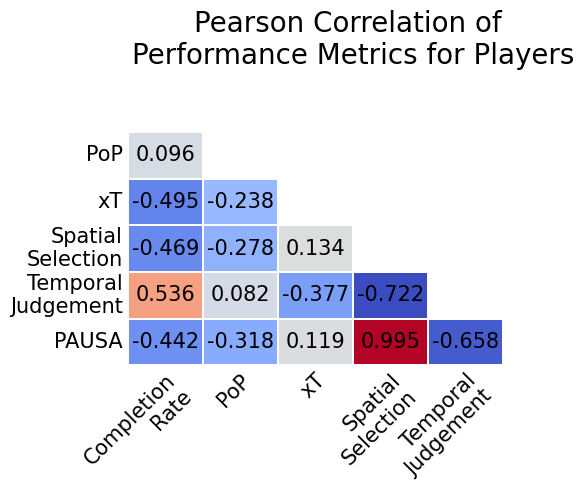

In [101]:
corr = metric_per_player[['success_rate', 'Pop', 'xT_value', 'spatial_selection',
       'temporal_judgment', 'pausa']]
corr = corr.corr()

corr = corr.rename(columns={
    "xT_value": "xT",
    "spatial_selection": "Spatial\nSelection",
    "temporal_judgment": "Temporal\nJudgement",
    "pausa": "PAUSA",
    "Pop": "PoP",
    "success_rate": "Completion\nRate"
}, index={
    "xT_value": "xT",
    "spatial_selection": "Spatial\nSelection",
    "temporal_judgment": "Temporal\nJudgement",
    "pausa": "PAUSA",
    "Pop": "PoP",
    "success_rate": "Completion\nRate"
})

visualize_correlation_matrix(corr, title="Pearson Correlation of \nPerformance Metrics for Players", figsize=(6, 4))

### Per Team Aggregation

In [ ]:
# obso per team: Pass / Team Average obso Calculation
obso_per_team = merged_df.groupby("team_name").agg(
    {
        "game_id": "nunique",
        "type_name": "size",
        "actual_spatial_obso": "mean",
        "optimal_spatial_obso": "mean",
        "optimal_temporal_obso": "mean",
        "spatial_selection": "mean",
        "temporal_judgment": "mean",
        "pausa": "mean",
        "time_diff": "mean",
        "Pop": "mean",
        "xT_value": "mean",
    }   
).rename(columns={"type_name": "count"})
obso_per_team = obso_per_team.merge(standings_df[['team', 'ppg']], left_index=True, right_on='team', how='left')
obso_per_team[obso_per_team["game_id"] >= 1].sort_values(by="pausa", ascending=False)

,game_id,count,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,time_diff,Pop,xT_value,team,ppg
8,1,179,0.008511,0.016080,0.018231,0.576011,0.904131,0.522960,0.199777,1.575866,0.001805,Bayer 04 Leverkusen,0.0
2,1,356,0.009456,0.017557,0.019808,0.574591,0.898242,0.516889,0.309213,1.448876,0.001873,FC Bayern München,3.0
1,1,208,0.010611,0.018973,0.020729,0.547503,0.925612,0.504414,0.084231,1.399038,0.004315,VfL Bochum 1848,3.0
5,1,293,0.008805,0.016374,0.018399,0.524838,0.902927,0.476302,0.233174,1.467577,0.003599,1. FC Köln,0.0
6,1,362,0.008394,0.015930,0.017739,0.525427,0.905285,0.475070,0.288950,1.470718,0.002706,FC St. Pauli,0.0
7,1,252,0.008715,0.016861,0.018870,0.512224,0.912897,0.469502,0.168730,1.429524,0.002811,F.C. Hansa Rostock,0.0
4,1,156,0.010076,0.018646,0.021608,0.512789,0.895588,0.459785,0.148974,1.541026,0.003376,1. FC Nürnberg,3.0
3,1,186,0.008137,0.016185,0.018330,0.493357,0.905840,0.443467,0.158925,1.458065,0.002121,1. FC Kaiserslautern,3.0
0,5,1524,0.008519,0.017730,0.019670,0.487824,0.911953,0.442601,0.140210,1.495171,0.002529,Fortuna Düsseldorf,1.8
9,1,189,0.008431,0.017415,0.019653,0.473055,0.889522,0.421065,0.243175,1.460952,0.003861,SSV Jahn Regensburg,0.0


In [ ]:
# obso per team: Game / Team Average obso Calculation
obso_per_team = merged_df.groupby("team_name").agg(
    {
        "game_id": "nunique",
        "type_name": "size",
        "actual_spatial_obso": "sum",
        "optimal_spatial_obso": "sum",
        "optimal_temporal_obso": "sum",
        "spatial_selection": "sum",
        "temporal_judgment": "sum",
        "pausa": "sum",
        "time_diff": "sum",
        "Pop": "sum",
        "xT_value": "sum",
    }   
).rename(columns={"type_name": "count"})

obso_per_team = obso_per_team.merge(standings_df[['team', 'ppg']], left_index=True, right_on='team', how='left')
for col in ["actual_spatial_obso", "optimal_spatial_obso", "optimal_temporal_obso", 
            "spatial_selection", "temporal_judgment", "pausa", 
            "xT_value", "Pop"]:
    obso_per_team[col] = obso_per_team[col] / obso_per_team["game_id"]
    
obso_per_team[obso_per_team["game_id"] >= 1].sort_values(by="pausa", ascending=False)

,game_id,count,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,time_diff,Pop,xT_value,team,ppg
2,1,356,3.366308,6.250447,7.051630,204.554328,319.774166,184.012528,110.08,515.800,0.666724,FC Bayern München,3.0
6,1,362,3.038716,5.766520,6.421599,190.204688,327.713334,171.975204,104.60,532.400,0.979596,FC St. Pauli,0.0
5,1,293,2.579778,4.797635,5.390922,153.777406,264.557521,139.556356,68.32,430.000,1.054457,1. FC Köln,0.0
0,5,1524,2.596503,5.403970,5.995284,148.688832,277.963218,134.904794,213.68,455.728,0.770900,Fortuna Düsseldorf,1.8
7,1,252,2.196285,4.249047,4.755260,129.080397,230.050105,118.314612,42.52,360.240,0.708339,F.C. Hansa Rostock,0.0
1,1,208,2.207065,3.946388,4.311670,113.880608,192.527353,104.918179,17.52,291.000,0.897595,VfL Bochum 1848,3.0
8,1,179,1.523550,2.878346,3.263377,103.105954,161.839389,93.609766,35.76,282.080,0.323114,Bayer 04 Leverkusen,0.0
3,1,186,1.513461,3.010384,3.409429,91.764334,168.486164,82.484802,29.56,271.200,0.394508,1. FC Kaiserslautern,3.0
9,1,189,1.593528,3.291425,3.714373,89.407377,168.119581,79.581306,45.96,276.120,0.729802,SSV Jahn Regensburg,0.0
4,1,156,1.571886,2.908772,3.370774,79.995087,139.711759,71.726399,23.24,240.400,0.526697,1. FC Nürnberg,3.0


In [ ]:
metric_per_team = obso_per_team[obso_per_team["game_id"] >= 1].reset_index(drop=True)
metric_per_team = metric_per_team.merge(
    pass_success_rate_per_team[["success_rate"]],
    left_on="team", right_on="team_name", how="left"
)
print(metric_per_team.shape)
metric_per_team.sort_values(by="ppg", ascending=False)

(10, 14)


,game_id,count,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,time_diff,Pop,xT_value,team,ppg,success_rate
0,1,186,1.513461,3.010384,3.409429,91.764334,168.486164,82.484802,29.56,271.200,0.394508,1. FC Kaiserslautern,3.0,0.741259
2,1,156,1.571886,2.908772,3.370774,79.995087,139.711759,71.726399,23.24,240.400,0.526697,1. FC Nürnberg,3.0,0.775424
5,1,356,3.366308,6.250447,7.051630,204.554328,319.774166,184.012528,110.08,515.800,0.666724,FC Bayern München,3.0,0.836478
9,1,208,2.207065,3.946388,4.311670,113.880608,192.527353,104.918179,17.52,291.000,0.897595,VfL Bochum 1848,3.0,0.756923
7,5,1524,2.596503,5.403970,5.995284,148.688832,277.963218,134.904794,213.68,455.728,0.770900,Fortuna Düsseldorf,1.8,0.813623
1,1,293,2.579778,4.797635,5.390922,153.777406,264.557521,139.556356,68.32,430.000,1.054457,1. FC Köln,0.0,0.798526
3,1,179,1.523550,2.878346,3.263377,103.105954,161.839389,93.609766,35.76,282.080,0.323114,Bayer 04 Leverkusen,0.0,0.688103
4,1,252,2.196285,4.249047,4.755260,129.080397,230.050105,118.314612,42.52,360.240,0.708339,F.C. Hansa Rostock,0.0,0.726817
6,1,362,3.038716,5.766520,6.421599,190.204688,327.713334,171.975204,104.60,532.400,0.979596,FC St. Pauli,0.0,0.817460
8,1,189,1.593528,3.291425,3.714373,89.407377,168.119581,79.581306,45.96,276.120,0.729802,SSV Jahn Regensburg,0.0,0.728477


In [119]:
bundesliga_2023_24_points = {
    "Bayer 04 Leverkusen": {"rank": 1, "points": 90},
    "VfB Stuttgart": {"rank": 2, "points": 73},
    "FC Bayern München": {"rank": 3, "points": 72},
    "RB Leipzig": {"rank": 4, "points": 65},
    "Borussia Dortmund": {"rank": 5, "points": 63},
    "Eintracht Frankfurt": {"rank": 6, "points": 47},
    "TSG Hoffenheim": {"rank": 7, "points": 46},
    "1. FC Heidenheim 1846": {"rank": 8, "points": 42},
    "SV Werder Bremen": {"rank": 9, "points": 42},
    "SC Freiburg": {"rank": 10, "points": 42},
    "FC Augsburg": {"rank": 11, "points": 39},
    "VfL Wolfsburg": {"rank": 12, "points": 37},
    "1. FSV Mainz 05": {"rank": 13, "points": 35},
    "Borussia Mönchengladbach": {"rank": 14, "points": 34},
    "1. FC Union Berlin": {"rank": 15, "points": 33},
    "VfL Bochum 1848": {"rank": 16, "points": 33},
    "1. FC Köln": {"rank": 17, "points": 27},
    "SV Darmstadt 98": {"rank": 18, "points": 17}
}

bepro_24_points = {
    "울산 HD FC": {"rank": 1, "points": 61},
    "김천 상무 프로축구단": {"rank": 2, "points": 56},
    "강원FC": {"rank": 3, "points": 55},
    "포항 스틸러스": {"rank": 4, "points": 51},
    "FC서울": {"rank": 5, "points": 50},
    "수원FC": {"rank": 6, "points": 49},
    "광주FC": {"rank": 7, "points": 43},
    "제주SK FC": {"rank": 8, "points": 41},
    "대구FC": {"rank": 9, "points": 38},
    "전북 현대 모터스": {"rank": 10, "points": 37},
    "대전 하나 시티즌": {"rank": 11, "points": 35},
    "인천 유나이티드": {"rank": 12, "points": 32}
}

if provider == "dfl":
    metric_per_team["Total Points"] = metric_per_team["team"].apply(lambda x: bundesliga_2023_24_points.get(x, {}).get("points", np.nan))
    metric_per_team["League Rank"] = metric_per_team["team"].apply(lambda x: bundesliga_2023_24_points.get(x, {}).get("rank", np.nan))
elif provider == "bepro":
    metric_per_team["Total Points"] = metric_per_team["team"].apply(lambda x: bepro_24_points.get(x, {}).get("points", np.nan))
    metric_per_team["League Rank"] = metric_per_team["team"].apply(lambda x: bepro_24_points.get(x, {}).get("rank", np.nan))
else:
    raise ValueError("Provider not supported.")

metric_per_team[metric_per_team["game_id"] >= 1].sort_values(by="ppg", ascending=False)

,game_id,count,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,time_diff,Pop,xT_value,team,ppg,success_rate,Total Points,League Rank
0,1,186,1.513461,3.010384,3.409429,91.764334,168.486164,82.484802,29.56,271.200,0.394508,1. FC Kaiserslautern,3.0,0.741259,NaN,NaN
2,1,156,1.571886,2.908772,3.370774,79.995087,139.711759,71.726399,23.24,240.400,0.526697,1. FC Nürnberg,3.0,0.775424,NaN,NaN
5,1,356,3.366308,6.250447,7.051630,204.554328,319.774166,184.012528,110.08,515.800,0.666724,FC Bayern München,3.0,0.836478,72.0,3.0
9,1,208,2.207065,3.946388,4.311670,113.880608,192.527353,104.918179,17.52,291.000,0.897595,VfL Bochum 1848,3.0,0.756923,33.0,16.0
7,5,1524,2.596503,5.403970,5.995284,148.688832,277.963218,134.904794,213.68,455.728,0.770900,Fortuna Düsseldorf,1.8,0.813623,NaN,NaN
1,1,293,2.579778,4.797635,5.390922,153.777406,264.557521,139.556356,68.32,430.000,1.054457,1. FC Köln,0.0,0.798526,27.0,17.0
3,1,179,1.523550,2.878346,3.263377,103.105954,161.839389,93.609766,35.76,282.080,0.323114,Bayer 04 Leverkusen,0.0,0.688103,90.0,1.0
4,1,252,2.196285,4.249047,4.755260,129.080397,230.050105,118.314612,42.52,360.240,0.708339,F.C. Hansa Rostock,0.0,0.726817,NaN,NaN
6,1,362,3.038716,5.766520,6.421599,190.204688,327.713334,171.975204,104.60,532.400,0.979596,FC St. Pauli,0.0,0.817460,NaN,NaN
8,1,189,1.593528,3.291425,3.714373,89.407377,168.119581,79.581306,45.96,276.120,0.729802,SSV Jahn Regensburg,0.0,0.728477,NaN,NaN


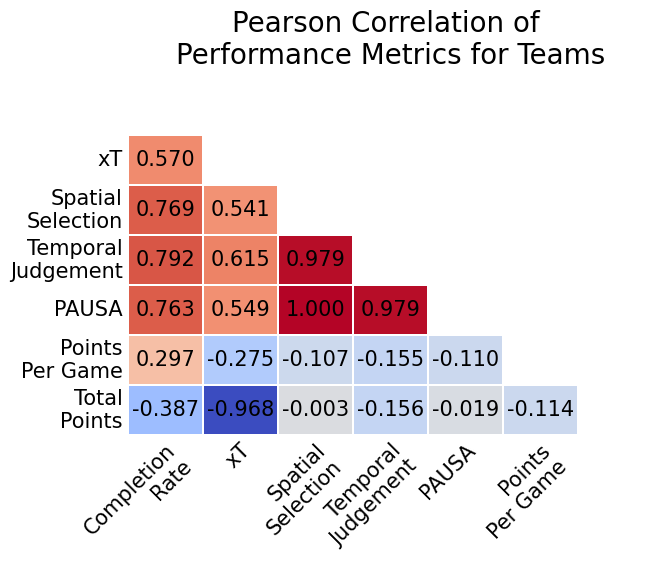

In [120]:
corr = metric_per_team[['success_rate', 'xT_value', 'spatial_selection',
       'temporal_judgment', 'pausa', 'ppg', 'Total Points']]

corr = corr.corr()

corr = corr.rename(columns={
    "xT_value": "xT",
    "spatial_selection": "Spatial\nSelection",
    "temporal_judgment": "Temporal\nJudgement",
    "pausa": "PAUSA",
    "Pop": "PoP",
    "success_rate": "Completion\nRate",
    "ppg": "Points\nPer Game",
    "Total Points": "Total\nPoints"
}, index={
    "xT_value": "xT",
    "spatial_selection": "Spatial\nSelection",
    "temporal_judgment": "Temporal\nJudgement",
    "pausa": "PAUSA",
    "Pop": "PoP",
    "success_rate": "Completion\nRate",
    "ppg": "Points\nPer Game",
    "Total Points": "Total\nPoints"
})

visualize_correlation_matrix(corr, title="Pearson Correlation of \nPerformance Metrics for Teams", figsize=(7, 5))

In [121]:
metric_per_team.sort_values("pausa", ascending=False)

,game_id,count,actual_spatial_obso,optimal_spatial_obso,optimal_temporal_obso,spatial_selection,temporal_judgment,pausa,time_diff,Pop,xT_value,team,ppg,success_rate,Total Points,League Rank
5,1,356,3.366308,6.250447,7.051630,204.554328,319.774166,184.012528,110.08,515.800,0.666724,FC Bayern München,3.0,0.836478,72.0,3.0
6,1,362,3.038716,5.766520,6.421599,190.204688,327.713334,171.975204,104.60,532.400,0.979596,FC St. Pauli,0.0,0.817460,NaN,NaN
1,1,293,2.579778,4.797635,5.390922,153.777406,264.557521,139.556356,68.32,430.000,1.054457,1. FC Köln,0.0,0.798526,27.0,17.0
7,5,1524,2.596503,5.403970,5.995284,148.688832,277.963218,134.904794,213.68,455.728,0.770900,Fortuna Düsseldorf,1.8,0.813623,NaN,NaN
4,1,252,2.196285,4.249047,4.755260,129.080397,230.050105,118.314612,42.52,360.240,0.708339,F.C. Hansa Rostock,0.0,0.726817,NaN,NaN
9,1,208,2.207065,3.946388,4.311670,113.880608,192.527353,104.918179,17.52,291.000,0.897595,VfL Bochum 1848,3.0,0.756923,33.0,16.0
3,1,179,1.523550,2.878346,3.263377,103.105954,161.839389,93.609766,35.76,282.080,0.323114,Bayer 04 Leverkusen,0.0,0.688103,90.0,1.0
0,1,186,1.513461,3.010384,3.409429,91.764334,168.486164,82.484802,29.56,271.200,0.394508,1. FC Kaiserslautern,3.0,0.741259,NaN,NaN
8,1,189,1.593528,3.291425,3.714373,89.407377,168.119581,79.581306,45.96,276.120,0.729802,SSV Jahn Regensburg,0.0,0.728477,NaN,NaN
2,1,156,1.571886,2.908772,3.370774,79.995087,139.711759,71.726399,23.24,240.400,0.526697,1. FC Nürnberg,3.0,0.775424,NaN,NaN
